In [1]:
'''
The goal is to develop and train a Deep Convolutional Generative Adversarial Network (DCGAN) 
capable of generating novel, realistic 32×32 pixel color images of cars. This involves training 
a model on a curated dataset of car images, enabling it to learn the underlying features and distribution 
of this specific class.

'''

'\nThe goal is to develop and train a Deep Convolutional Generative Adversarial Network (DCGAN) \ncapable of generating novel, realistic 32×32 pixel color images of cars. This involves training \na model on a curated dataset of car images, enabling it to learn the underlying features and distribution \nof this specific class.\n\n'

In [2]:
''' 
Objectives

    Data Curation: Create a specialized training dataset by filtering the CIFAR-10 dataset to exclusively 
    contain images of cars (class label 1). This dataset will serve as the "ground truth" for training the 
    network.

    Model Architecture:

        Generator (G): Design a generator model that takes a 100-dimensional random noise vector 
        (from a latent space) as input and uses a series of transposed convolutional layers to upsample it 
        into a 32×32×3 image.

        Discriminator (D): Design a discriminator model using standard convolutional layers to take 
        an image as input and output a single probability score indicating whether the image is real 
        (from the curated dataset) or fake (from the generator).

    Adversarial Training: Implement a stable training loop where the generator and discriminator are trained 
    in an adversarial manner.

        The discriminator will be trained to maximize its ability to distinguish between real car images 
        and generated ones.

        The generator will be trained to create images that successfully fool the discriminator, 
        thereby minimizing the discriminator's classification accuracy.

    Evaluation: Periodically evaluate the generator's performance by visually inspecting the quality, 
    diversity, and realism of the generated images. The final saved model should be capable of producing 
    convincing synthetic car images.

Expected Outcome

The final deliverable is a trained generator model that has learned the features of cars from the 
CIFAR-10 dataset. When provided with a random noise vector, this model should be able to synthesize a new 
and unique car image that is visually consistent with the training data.


'''

' \nObjectives\n\n    Data Curation: Create a specialized training dataset by filtering the CIFAR-10 dataset to exclusively \n    contain images of cars (class label 1). This dataset will serve as the "ground truth" for training the \n    network.\n\n    Model Architecture:\n\n        Generator (G): Design a generator model that takes a 100-dimensional random noise vector \n        (from a latent space) as input and uses a series of transposed convolutional layers to upsample it \n        into a 32×32×3 image.\n\n        Discriminator (D): Design a discriminator model using standard convolutional layers to take \n        an image as input and output a single probability score indicating whether the image is real \n        (from the curated dataset) or fake (from the generator).\n\n    Adversarial Training: Implement a stable training loop where the generator and discriminator are trained \n    in an adversarial manner.\n\n        The discriminator will be trained to maximize its abilit

Training data shape: (50000, 32, 32, 3)
Training labels shape: (50000, 1)
Test data shape: (10000, 32, 32, 3)
Test labels shape: (10000, 1)

--- A few examples from the dataset: ---


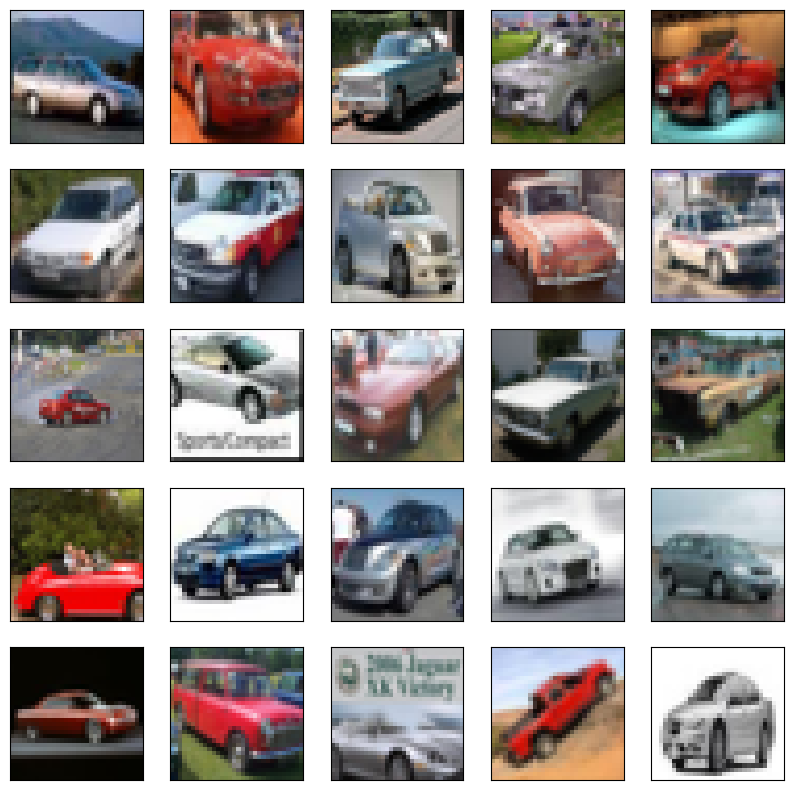

In [3]:
# Import the load_data function from the CIFAR-10 dataset module in Keras.
from tensorflow.keras.datasets.cifar10 import load_data
import matplotlib.pyplot as plt

# --- Load the CIFAR-10 Dataset ---
# The load_data() function returns two tuples.
# 1. The first tuple contains the training images (trainX) and their corresponding labels (trainy).
# 2. The second tuple contains the testing images (testX) and their labels (testy).
(trainX, trainy), (testX, testy) = load_data()
print(f"Training data shape: {trainX.shape}")
print(f"Training labels shape: {trainy.shape}")
print(f"Test data shape: {testX.shape}")
print(f"Test labels shape: {testy.shape}")

# --- Filter for Car Images (Label == 1) ---
# Select the indices where the label is 1.
selected_ix = trainy.flatten() == 1
# Use these indices to select only the car images from trainX.
trainX = trainX[selected_ix]


# --- Visualize some of the training images ---
print("\n--- A few examples from the dataset: ---")
plt.figure(figsize=(10, 10))
for i in range(25):
    # Create a 5x5 grid of subplots
    plt.subplot(5, 5, i + 1)
    plt.xticks([]) # Remove x-axis ticks
    plt.yticks([]) # Remove y-axis ticks
    plt.grid(False) # Remove grid lines
    # Display the i-th image. The `cmap` argument is ignored for RGB images.
    plt.imshow(trainX[i])

plt.show()

In [4]:
# Import the data loading function and numpy for numerical operations
import numpy as np

def load_real_samples():
    """
    Loads the CIFAR-10 dataset, filters it for car images (label 1),
    and preprocesses them.
    
    Returns:
        np.array: A NumPy array of the real CIFAR-10 car images, converted
                  to float32 and normalized to the range [-1, 1].
    """
   
    # Convert the pixel values from integers to floating-point numbers.
    X = trainX.astype('float32')
    
    # Normalize the pixel values from the range [0, 255] to [-1, 1].
    X = (X - 127.5) / 127.5
    
    # Print the size of the filtered dataset
    print(f"Filtered Dataset Shape (Cars Only): {X.shape}")
    
    return X

# --- Demonstrate the function and verify the output ---
# Load the preprocessed real images
real_images = load_real_samples()

# Print the shape and data type of the loaded data
print(f"Shape of loaded data: {real_images.shape}")
print(f"Data type: {real_images.dtype}")

# Verify the new range of pixel values
print(f"Min pixel value: {real_images.min():.2f}")
print(f"Max pixel value: {real_images.max():.2f}")

Filtered Dataset Shape (Cars Only): (5000, 32, 32, 3)
Shape of loaded data: (5000, 32, 32, 3)
Data type: float32
Min pixel value: -1.00
Max pixel value: 1.00


In [5]:
'''
Defining the Discriminator Network 🕵️

The Discriminator (D) is the second core component of our GAN. Its job is to act as a binary classifier. 
It takes an image as input (either a real one from the CIFAR-10 dataset or a fake one from our Generator) 
and outputs a single probability indicating how likely it is that the input image is real.

The Discriminator is essentially a standard Convolutional Neural Network (CNN). Through training, 
it learns the features that define a "realistic" CIFAR-10 image.

The architecture follows a common pattern for GANs:

    A series of convolutional layers (Conv2D) to extract features.

    Downsampling using strides to reduce the image dimensions.

    LeakyReLU activation, which is known to work well in GANs.

    A final Dense layer with a sigmoid activation to output a single probability.


 '''

'\nDefining the Discriminator Network 🕵️\n\nThe Discriminator (D) is the second core component of our GAN. Its job is to act as a binary classifier. \nIt takes an image as input (either a real one from the CIFAR-10 dataset or a fake one from our Generator) \nand outputs a single probability indicating how likely it is that the input image is real.\n\nThe Discriminator is essentially a standard Convolutional Neural Network (CNN). Through training, \nit learns the features that define a "realistic" CIFAR-10 image.\n\nThe architecture follows a common pattern for GANs:\n\n    A series of convolutional layers (Conv2D) to extract features.\n\n    Downsampling using strides to reduce the image dimensions.\n\n    LeakyReLU activation, which is known to work well in GANs.\n\n    A final Dense layer with a sigmoid activation to output a single probability.\n\n\n '

In [6]:
# Import necessary layers and optimizer from TensorFlow/Keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, LeakyReLU

def define_discriminator(in_shape=(32, 32, 3)):
    """
    Defines the discriminator model architecture.
    
    Args:
        in_shape (tuple): The shape of the input images (height, width, channels).
        
    Returns:
        A compiled Keras model for the discriminator.
    """
    model = Sequential(name="Discriminator")
    
    # --- Input Layer & First Convolutional Block ---
    # Input shape: 32x32x3. Output shape: 32x32x64
    model.add(Conv2D(64, (3, 3), padding='same', input_shape=in_shape))
    # LeakyReLU is used to prevent "dying ReLU" problem, which helps gradient flow.
    model.add(LeakyReLU(alpha=0.2))

    # --- Downsampling Blocks ---
    # Each block uses a Conv2D layer with strides=(2,2) to halve the image dimensions.
    
    # Block 1: 32x32 -> 16x16. Output: 16x16x128
    model.add(Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    # Block 2: 16x16 -> 8x8. Output: 8x8x128
    model.add(Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    # Block 3: 8x8 -> 4x4. Output: 4x4x256
    model.add(Conv2D(256, (3, 3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    # --- Classifier Head ---
    # Flatten the 4x4x256 feature map into a single vector.
    model.add(Flatten())
    # Dropout layer for regularization to prevent overfitting.
    model.add(Dropout(0.4))
    # Final output layer with a single neuron and sigmoid activation.
    # Sigmoid outputs a probability between 0 (fake) and 1 (real).
    model.add(Dense(1, activation='sigmoid'))

    # --- Compile the Model ---
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    # Binary cross-entropy is the standard loss function for binary classification.
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    return model

# --- Create and Summarize the Discriminator ---
# Create an instance of the discriminator
discriminator = define_discriminator()
# Print the model summary to see the architecture, output shapes, and number of parameters.
print("--- Discriminator Architecture ---")
discriminator.summary()

--- Discriminator Architecture ---


d:\Program Files\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
d:\Program Files\Python313\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 4, 4, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         4,097 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 522,497 (1.99 MB)

 Trainable params: 522,497 (1.99 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
'''
Preparing Data Batches for Training 🎲

To train our discriminator, we need to feed it batches of both real and fake images. 
We'll create a set of helper functions to prepare these batches on the fly.

    generate_real_samples: This will randomly select images from our pre-processed CIFAR-10 
    dataset and label them as "real" (class label 1).

    generate_latent_points: This will create random points in the latent space, which will 
    serve as input for the generator.

    generate_fake_samples: This will use the generator to create fake images from the latent 
    points and label them as "fake" (class label 0).

'''

'\nPreparing Data Batches for Training 🎲\n\nTo train our discriminator, we need to feed it batches of both real and fake images. \nWe\'ll create a set of helper functions to prepare these batches on the fly.\n\n    generate_real_samples: This will randomly select images from our pre-processed CIFAR-10 \n    dataset and label them as "real" (class label 1).\n\n    generate_latent_points: This will create random points in the latent space, which will \n    serve as input for the generator.\n\n    generate_fake_samples: This will use the generator to create fake images from the latent \n    points and label them as "fake" (class label 0).\n\n'

In [8]:
# Import necessary functions from numpy
from numpy.random import randint, randn
from numpy import ones, zeros

# --- A. Function to select a batch of real samples ---

def generate_real_samples(dataset, n_samples):
    """
    Selects a random batch of real images from the dataset.
    
    Args:
        dataset (np.array): The full dataset of real, pre-processed images.
        n_samples (int): The number of samples to select (i.e., the batch size).
        
    Returns:
        tuple: A tuple containing the batch of images (X) and their "real" labels (y).
    """
    # Choose random indices from the dataset.
    ix = randint(0, dataset.shape[0], n_samples)
    
    # Retrieve the images using the random indices.
    X = dataset[ix]
    
    # Create the "real" labels, an array of ones.
    y = ones((n_samples, 1))
    
    return X, y

# --- B. Functions to generate a batch of fake samples ---

# we
# must generate fake samples using the Generator model. This is how the
# discriminator learns to provide useful feedback.

def generate_latent_points(latent_dim, n_samples):
    """
    Generates random points in the latent space (input for the generator).

    Args:
        latent_dim (int): The dimension of the latent space (e.g., 100).
        n_samples (int): The number of points to generate (i.e., the batch size).

    Returns:
        np.array: An array of random points from a standard normal distribution.
    """
    # Generate random input data from a standard normal distribution.
    x_input = randn(latent_dim * n_samples)
    
    # Reshape into a batch of inputs for the network.
    x_input = x_input.reshape(n_samples, latent_dim)
    
    return x_input


def generate_fake_samples(g_model, latent_dim, n_samples):
    """
    Generates a batch of fake images using the generator model.
    This version runs silently by setting verbose=0.

    Args:
        g_model (keras.Model): The generator model.
        latent_dim (int): The dimension of the latent space.
        n_samples (int): The number of fake samples to generate.

    Returns:
        tuple: A tuple containing the batch of fake images (X) and their "fake" labels (y).
    """
    # Generate points in the latent space.
    x_input = generate_latent_points(latent_dim, n_samples)
    
    # Use the generator model to predict outputs (generate images).
    # Add verbose=0 here to suppress the progress bar.
    X = g_model.predict(x_input, verbose=0)
    
    # Create the "fake" labels, an array of zeros.
    y = zeros((n_samples, 1))
    
    return X, y

In [9]:
''' 
Sanity Check: Training the Discriminator in Isolation 🧪

Before building the full GAN, it's a good practice to test the discriminator on a simplified task. Here,
 we'll train it to distinguish between real images from the CIFAR-10 dataset and fake images composed of 
 simple random noise.

This helps us verify that the discriminator's architecture is sound and that it can learn to classify 
images correctly. If it can't even master this basic task, it will certainly fail in the more complex GAN setup.

    Important Note: This is not the final GAN training loop. In the complete GAN, the discriminator is 
    trained against the images produced by the generator, not just random noise. This function is only 
    a preliminary check.

'''

" \nSanity Check: Training the Discriminator in Isolation 🧪\n\nBefore building the full GAN, it's a good practice to test the discriminator on a simplified task. Here,\n we'll train it to distinguish between real images from the CIFAR-10 dataset and fake images composed of \n simple random noise.\n\nThis helps us verify that the discriminator's architecture is sound and that it can learn to classify \nimages correctly. If it can't even master this basic task, it will certainly fail in the more complex GAN setup.\n\n    Important Note: This is not the final GAN training loop. In the complete GAN, the discriminator is \n    trained against the images produced by the generator, not just random noise. This function is only \n    a preliminary check.\n\n"

In [10]:


from numpy.random import rand
from numpy import zeros

def generate_noise_samples(n_samples):
    """Generates random noise images and 'fake' labels."""
    # Generate uniform random numbers in [0,1]
    X = rand(32 * 32 * 3 * n_samples)
    # Rescale to [-1, 1] to match real image preprocessing
    X = -1 + X * 2
    # Reshape into a batch of color images
    X = X.reshape((n_samples, 32, 32, 3))
    # Generate 'fake' class labels (0)
    y = zeros((n_samples, 1))
    return X, y

def train_discriminator(model, dataset, n_iter=20, n_batch=128):
    """
    Trains the discriminator model in isolation on real and random noise images.
    
    Args:
        model (keras.Model): The compiled discriminator model.
        dataset (np.array): The full, pre-processed real image dataset.
        n_iter (int): The number of training iterations.
        n_batch (int): The total number of samples per batch.
    """
    half_batch = int(n_batch / 2)
    # Manually loop through training iterations
    for i in range(n_iter):
        # --- Train on a half-batch of real samples ---
        # Get randomly selected 'real' samples

        X_real, y_real = generate_real_samples(dataset, half_batch)
        # Update discriminator model weights using train_on_batch()
        # We ignore the loss, only tracking accuracy
        _, real_acc = model.train_on_batch(X_real, y_real)

        # --- Train on a half-batch of fake (noise) samples ---
        # Generate 'fake' examples (in this case, random noise)
        
        X_fake, y_fake = generate_noise_samples(half_batch)
        # Update discriminator model weights
        _, fake_acc = model.train_on_batch(X_fake, y_fake)

        # --- Summarize performance ---
        # The f-string formatting is a modern and readable alternative to the % operator.
        print(f"> Iteration {i+1}, Accuracy on Real: {real_acc*100:.0f}%, Accuracy on Fake: {fake_acc*100:.0f}%")

# --- Example of how to run this function ---
# 1. Create the discriminator model
d_model = define_discriminator()
# 2. Load the real image data
real_dataset = load_real_samples()
# 3. Run the training function
print("--- Starting Discriminator Sanity Check ---")
train_discriminator(d_model, real_dataset)

Filtered Dataset Shape (Cars Only): (5000, 32, 32, 3)
--- Starting Discriminator Sanity Check ---
> Iteration 1, Accuracy on Real: 61%, Accuracy on Fake: 31%
> Iteration 2, Accuracy on Real: 54%, Accuracy on Fake: 42%
> Iteration 3, Accuracy on Real: 54%, Accuracy on Fake: 49%
> Iteration 4, Accuracy on Real: 56%, Accuracy on Fake: 55%
> Iteration 5, Accuracy on Real: 60%, Accuracy on Fake: 62%
> Iteration 6, Accuracy on Real: 66%, Accuracy on Fake: 69%
> Iteration 7, Accuracy on Real: 71%, Accuracy on Fake: 73%
> Iteration 8, Accuracy on Real: 74%, Accuracy on Fake: 76%
> Iteration 9, Accuracy on Real: 77%, Accuracy on Fake: 79%
> Iteration 10, Accuracy on Real: 80%, Accuracy on Fake: 81%
> Iteration 11, Accuracy on Real: 82%, Accuracy on Fake: 83%
> Iteration 12, Accuracy on Real: 83%, Accuracy on Fake: 84%
> Iteration 13, Accuracy on Real: 85%, Accuracy on Fake: 85%
> Iteration 14, Accuracy on Real: 86%, Accuracy on Fake: 86%
> Iteration 15, Accuracy on Real: 87%, Accuracy on Fake: 

In [11]:
''' 
Defining the Generator Network 🎨

The Generator (G) is the artist in the GAN duo. It learns to create synthetic images that are 
indistinguishable from real ones. It takes a random vector from a high-dimensional "latent space" 
as input and upsamples it through a series of layers to produce an image.

The architecture starts with a Dense layer to create a foundation, which is then reshaped into a 
small feature map. A sequence of Conv2DTranspose layers progressively increases the spatial dimensions 
until the target image size of 32*32*3 is reached.

'''

' \nDefining the Generator Network 🎨\n\nThe Generator (G) is the artist in the GAN duo. It learns to create synthetic images that are \nindistinguishable from real ones. It takes a random vector from a high-dimensional "latent space" \nas input and upsamples it through a series of layers to produce an image.\n\nThe architecture starts with a Dense layer to create a foundation, which is then reshaped into a \nsmall feature map. A sequence of Conv2DTranspose layers progressively increases the spatial dimensions \nuntil the target image size of 32*32*3 is reached.\n\n'

In [12]:
# Import necessary layers and models from TensorFlow/Keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, Conv2D, Conv2DTranspose, LeakyReLU

def define_generator(latent_dim):
    """
    Defines the generator model architecture.
    
    Args:
        latent_dim (int): The dimension of the latent space vector (e.g., 100).
        
    Returns:
        A Keras model for the generator. Note: This model is not compiled.
    """
    model = Sequential(name="Generator")
    
    # --- Foundation Block: Create a small feature map from the latent vector ---
    # We'll start with a 4x4 feature map.

    n_nodes = 256 * 4 * 4
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    
    # Reshape the 1D output from the Dense layer into a 3D tensor (4x4x256)
    model.add(Reshape((4, 4, 256)))

    # --- Upsampling Blocks ---
    # Each block uses Conv2DTranspose with strides=(2,2) to double the spatial dimensions.
    
    # Block 1: Upsample from 4x4 to 8x8. Output: 8x8x128
    model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    # Block 2: Upsample from 8x8 to 16x16. Output: 16x16x128
    model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    
    # Block 3: Upsample from 16x16 to 32x32. Output: 32x32x128
    model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    # --- Output Layer ---
    # A final Conv2D layer to generate the 3-channel (RGB) image.
    # The 'tanh' activation is crucial as it squashes the output pixel values
    # to the range [-1, 1], matching the normalization of our real images.
    model.add(Conv2D(3, (3, 3), activation='tanh', padding='same'))
    
    return model

# --- Create and Summarize the Generator ---
# Define the dimension of the latent space
latent_dimension = 100
# Create an instance of the generator
generator = define_generator(latent_dimension)
# Print the model summary
print("--- Generator Architecture ---")
generator.summary()

--- Generator Architecture ---


d:\Program Files\Python313\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "Generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 4096)           │       413,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 8, 8, 128)      │       524,416 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_9 (LeakyReLU)       │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 16, 16, 128)    │       262,272 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_10 (LeakyReLU)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 32, 32, 128)    │       262,272 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_11 (LeakyReLU)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 32, 32, 3)      │         3,459 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,466,115 (5.59 MB)

 Trainable params: 1,466,115 (5.59 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
def define_discriminator(in_shape=(32, 32, 3)):
    """
    Defines the discriminator model architecture.
    
    Args:
        in_shape (tuple): The shape of the input images (height, width, channels).
        
    Returns:
        A compiled Keras model for the discriminator.
    """
    model = Sequential(name="Discriminator")
    
    # --- Input Layer & First Convolutional Block ---
    # Input shape: 32x32x3. Output shape: 32x32x64
    model.add(Conv2D(64, (3, 3), padding='same', input_shape=in_shape))
    # LeakyReLU is used to prevent the "dying ReLU" problem.
    model.add(LeakyReLU(alpha=0.2))

    # --- Downsampling Blocks ---
    # Each block uses a Conv2D layer with strides=(2,2) to halve the image dimensions.
    
    # Block 1: 32x32 -> 16x16. Output: 16x16x128
    model.add(Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    # Block 2: 16x16 -> 8x8. Output: 8x8x128
    model.add(Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    # Block 3: 8x8 -> 4x4. Output: 4x4x256
    model.add(Conv2D(256, (3, 3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    # --- Classifier Head ---
    # Flatten the 4x4x256 feature map into a single vector.
    model.add(Flatten())
    # Dropout layer for regularization to prevent overfitting.
    model.add(Dropout(0.4))
    # Final output layer with a single neuron and sigmoid activation.
    model.add(Dense(1, activation='sigmoid'))

    # --- Compile the Model ---
    # The Adam optimizer is used with parameters recommended by the original DCGAN paper.
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    # Binary cross-entropy is the standard loss function for binary classification.
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    return model

# --- Create and Summarize the Discriminator ---
# Create an instance of the discriminator
discriminator = define_discriminator()
# Print the model summary to see the architecture and number of parameters.
print("--- Discriminator Architecture ---")
discriminator.summary()

--- Discriminator Architecture ---


Model: "Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_12 (LeakyReLU)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_13 (LeakyReLU)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_14 (LeakyReLU)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 4, 4, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_15 (LeakyReLU)      │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │         4,097 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 522,497 (1.99 MB)

 Trainable params: 522,497 (1.99 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
''' 
Creating the Combined GAN Model 🤝

Now we assemble the complete GAN. This combined model chains the Generator (G) and the Discriminator (D) together.
 Its purpose is to train the Generator.

The training process works as follows:

    The Generator takes a latent vector and produces a fake image.

    This fake image is fed directly into the Discriminator.

    The Discriminator evaluates the image and outputs a probability (how "real" it thinks the image is).

    We use a special trick: we tell the GAN model that we want the Discriminator to output a "1" (real). 
    The GAN's loss is calculated based on how far the Discriminator's output is from this target.

    Crucially, we freeze the Discriminator's weights within this combined model. When we train the GAN, 
    the error signal flows backward through the frozen Discriminator and only updates the Generator's weights.

This process forces the Generator to adjust its weights to produce images that are better at "fooling" the 
Discriminator.


'''

' \nCreating the Combined GAN Model 🤝\n\nNow we assemble the complete GAN. This combined model chains the Generator (G) and the Discriminator (D) together.\n Its purpose is to train the Generator.\n\nThe training process works as follows:\n\n    The Generator takes a latent vector and produces a fake image.\n\n    This fake image is fed directly into the Discriminator.\n\n    The Discriminator evaluates the image and outputs a probability (how "real" it thinks the image is).\n\n    We use a special trick: we tell the GAN model that we want the Discriminator to output a "1" (real). \n    The GAN\'s loss is calculated based on how far the Discriminator\'s output is from this target.\n\n    Crucially, we freeze the Discriminator\'s weights within this combined model. When we train the GAN, \n    the error signal flows backward through the frozen Discriminator and only updates the Generator\'s weights.\n\nThis process forces the Generator to adjust its weights to produce images that are be

In [15]:

def define_gan(g_model, d_model):
    """
    Defines the combined GAN model for training the generator.
    
    Args:
        g_model (keras.Model): The generator model.
        d_model (keras.Model): The compiled discriminator model.
        
    Returns:
        A compiled Keras model for the complete GAN.
    """
    # --- Freeze the Discriminator's Weights ---
    # This is a critical step. When we train the combined GAN model,
    # we only want to update the generator's weights. By setting trainable to False,
    # we prevent the discriminator's weights from being modified during this phase.
    d_model.trainable = False
    
    # --- Create the Combined Sequential Model ---
    model = Sequential(name="GAN")
    
    # Add the generator model (G)
    model.add(g_model)
    # Add the discriminator model (D)
    model.add(d_model)
    
    # --- Compile the GAN Model ---
    # Use the same Adam optimizer settings as the discriminator.
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    
    # The GAN is also compiled with binary_crossentropy loss. It will be trained
    # to make the discriminator output '1' (real) for the generator's fake images.
    model.compile(loss='binary_crossentropy', optimizer=opt)
    
    return model

# --- Create and Summarize the Full GAN ---
# Define the latent space dimension
latent_dim = 100
# Create the discriminator
d_model = define_discriminator()
# Create the generator
g_model = define_generator(latent_dim)
# Create the GAN
gan_model = define_gan(g_model, d_model)

# Print the model summary
print("--- Full GAN Architecture ---")
gan_model.summary()

--- Full GAN Architecture ---


Model: "GAN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Generator (Sequential)          │ (None, 32, 32, 3)      │     1,466,115 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Discriminator (Sequential)      │ (None, 1)              │       522,497 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,988,612 (7.59 MB)

 Trainable params: 1,466,115 (5.59 MB)

 Non-trainable params: 522,497 (1.99 MB)

In [16]:
'''
This helper function creates a plot of sample images, allowing us to qualitatively assess whether the 
generator is learning meaningful features or just producing noise.

This revised function will:

    Take a batch of 25 sample images generated at a specific epoch.

    Rescale the pixel values from the [-1, 1] range (used by the network) to the [0, 1] range (for visualization).

    Display them in a 5x5 grid directly in the cell output.



'''

'\nThis helper function creates a plot of sample images, allowing us to qualitatively assess whether the \ngenerator is learning meaningful features or just producing noise.\n\nThis revised function will:\n\n    Take a batch of 25 sample images generated at a specific epoch.\n\n    Rescale the pixel values from the [-1, 1] range (used by the network) to the [0, 1] range (for visualization).\n\n    Display them in a 5x5 grid directly in the cell output.\n\n\n\n'

--- Demonstrating the plot function with random noise ---


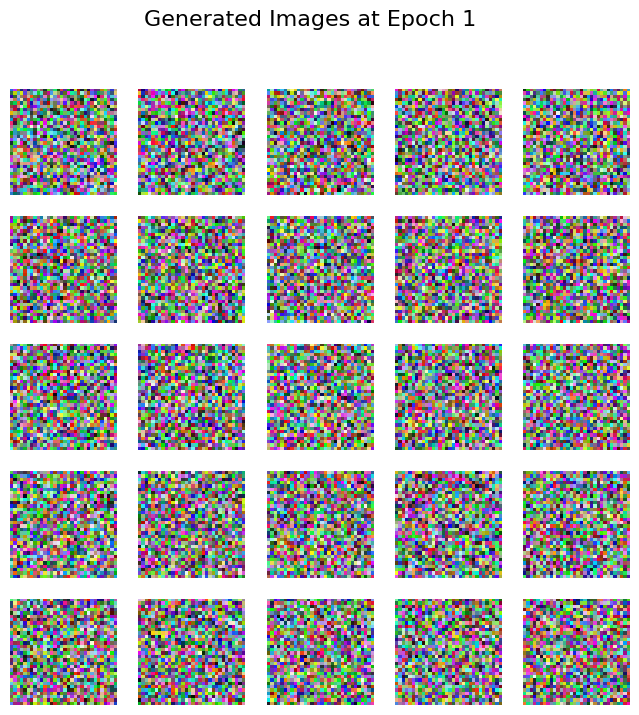

In [17]:
# Import necessary libraries for plotting and numerical operations
import matplotlib.pyplot as plt
import numpy as np

def show_generated_images(examples, epoch):
    """
    Rescales and plots 25 generated images in a 5x5 grid.
    
    Args:
        examples (np.array): A batch of 25 images from the generator.
        epoch (int): The current epoch number, used for the plot title.
    """
    # Create a figure to contain the plot.
    plt.figure(figsize=(8, 8))
    
    # Scale images from [-1, 1] to [0, 1] for correct plotting.
    examples = (examples + 1) / 2.0
    
    # Plot 25 images in a 5x5 grid
    for i in range(25):
        # Define subplot
        plt.subplot(5, 5, 1 + i)
        # Turn off axis labels
        plt.axis('off')
        # Plot raw pixel data
        plt.imshow(examples[i])
        
    # Add a title to the entire figure
    plt.suptitle(f'Generated Images at Epoch {epoch + 1}', fontsize=16)
    
    # Show the plot
    plt.show()

# --- Example of how to use the function ---
print("--- Demonstrating the plot function with random noise ---")
# Generate 25 random "images" (as a stand-in for generator output)
# The shape is (number_of_images, height, width, channels)
dummy_images = np.random.rand(25, 32, 32, 3) * 2 - 1 # Data in [-1, 1] range

# Call the function to display the images for a sample epoch
show_generated_images(dummy_images, epoch=0)

In [18]:
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=150):
    """
    Evaluates discriminator performance, displays generated images, and saves the generator model.
    Args:
        epoch (int): The current training epoch.
        g_model (keras.Model): The generator model.
        d_model (keras.Model): The discriminator model.
        dataset (np.array): The full, pre-processed real image dataset.
        latent_dim (int): The dimension of the latent space.
        n_samples (int): The number of samples to use for evaluation.
    """
    # --- Evaluate discriminator on real samples ---
    X_real, y_real = generate_real_samples(dataset, n_samples)
    # Add verbose=0 to run silently
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)

    # --- Evaluate discriminator on fake samples ---
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    # Add verbose=0 to run silently
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)

    # --- Summarize and print performance ---
    # Note: This print statement is inside summarize_performance, not the main train loop.
    print(f"    -> Evaluation at Epoch {epoch+1}: Accuracy Real: {acc_real*100:.0f}%, Fake: {acc_fake*100:.0f}%")

    # --- Display a plot of generated images ---
    show_generated_images(x_fake, epoch)

    # --- Save the generator model as a checkpoint ---
    filename = f'generator_model_{epoch + 1:03d}.h5'
    g_model.save(filename)

In [19]:
'''
The GAN Training Loop 🚀

This is where the magic happens. We will now write the main training loop that pits the generator and 
discriminator against each other over many epochs.

For each batch of data within an epoch, we perform three key steps:

    Train the Discriminator on Real Data: We show the discriminator a half-batch of real images from our 
    dataset and teach it to classify them as "real" (label 1).

    Train the Discriminator on Fake Data: We use the generator to create a half-batch of fake images. 
    We then show these to the discriminator and teach it to classify them as "fake" (label 0).

    Train the Generator: We use the combined gan_model (where the discriminator's weights are frozen) to 
    train the generator. We generate a full batch of fake images and try to "trick" the discriminator into 
    classifying them as "real" (label 1). The error signal from this trickery flows back and updates only 
    the generator's weights, teaching it how to make better fakes.

'''

'\nThe GAN Training Loop 🚀\n\nThis is where the magic happens. We will now write the main training loop that pits the generator and \ndiscriminator against each other over many epochs.\n\nFor each batch of data within an epoch, we perform three key steps:\n\n    Train the Discriminator on Real Data: We show the discriminator a half-batch of real images from our \n    dataset and teach it to classify them as "real" (label 1).\n\n    Train the Discriminator on Fake Data: We use the generator to create a half-batch of fake images. \n    We then show these to the discriminator and teach it to classify them as "fake" (label 0).\n\n    Train the Generator: We use the combined gan_model (where the discriminator\'s weights are frozen) to \n    train the generator. We generate a full batch of fake images and try to "trick" the discriminator into \n    classifying them as "real" (label 1). The error signal from this trickery flows back and updates only \n    the generator\'s weights, teaching it

Filtered Dataset Shape (Cars Only): (5000, 32, 32, 3)

--- Starting Full GAN Training (Clean Output) ---


d:\Program Files\Python313\Lib\site-packages\keras\src\backend\tensorflow\trainer.py:83: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


Epoch 1/200 | D Loss Real: 0.739 | D Loss Fake: 0.742 | G Loss: 0.621
Epoch 2/200 | D Loss Real: 0.840 | D Loss Fake: 0.843 | G Loss: 0.484
Epoch 3/200 | D Loss Real: 0.893 | D Loss Fake: 0.895 | G Loss: 0.427
Epoch 4/200 | D Loss Real: 0.926 | D Loss Fake: 0.928 | G Loss: 0.394
Epoch 5/200 | D Loss Real: 0.950 | D Loss Fake: 0.951 | G Loss: 0.372
Epoch 6/200 | D Loss Real: 0.968 | D Loss Fake: 0.969 | G Loss: 0.356
Epoch 7/200 | D Loss Real: 0.982 | D Loss Fake: 0.983 | G Loss: 0.344
Epoch 8/200 | D Loss Real: 0.994 | D Loss Fake: 0.994 | G Loss: 0.334
Epoch 9/200 | D Loss Real: 1.003 | D Loss Fake: 1.004 | G Loss: 0.327
Epoch 10/200 | D Loss Real: 1.011 | D Loss Fake: 1.012 | G Loss: 0.320
    -> Evaluation at Epoch 10: Accuracy Real: 24%, Fake: 0%


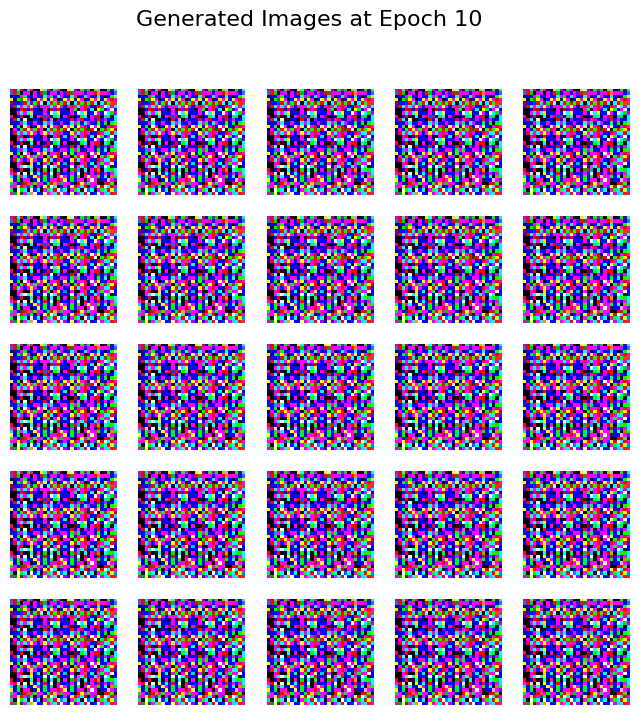

Epoch 11/200 | D Loss Real: 1.108 | D Loss Fake: 1.122 | G Loss: 0.315
Epoch 12/200 | D Loss Real: 1.091 | D Loss Fake: 1.095 | G Loss: 0.310
Epoch 13/200 | D Loss Real: 1.091 | D Loss Fake: 1.093 | G Loss: 0.306
Epoch 14/200 | D Loss Real: 1.092 | D Loss Fake: 1.093 | G Loss: 0.302
Epoch 15/200 | D Loss Real: 1.093 | D Loss Fake: 1.094 | G Loss: 0.299
Epoch 16/200 | D Loss Real: 1.094 | D Loss Fake: 1.095 | G Loss: 0.296
Epoch 17/200 | D Loss Real: 1.095 | D Loss Fake: 1.096 | G Loss: 0.293
Epoch 18/200 | D Loss Real: 1.096 | D Loss Fake: 1.097 | G Loss: 0.291
Epoch 19/200 | D Loss Real: 1.097 | D Loss Fake: 1.098 | G Loss: 0.289
Epoch 20/200 | D Loss Real: 1.098 | D Loss Fake: 1.099 | G Loss: 0.287
    -> Evaluation at Epoch 20: Accuracy Real: 25%, Fake: 0%


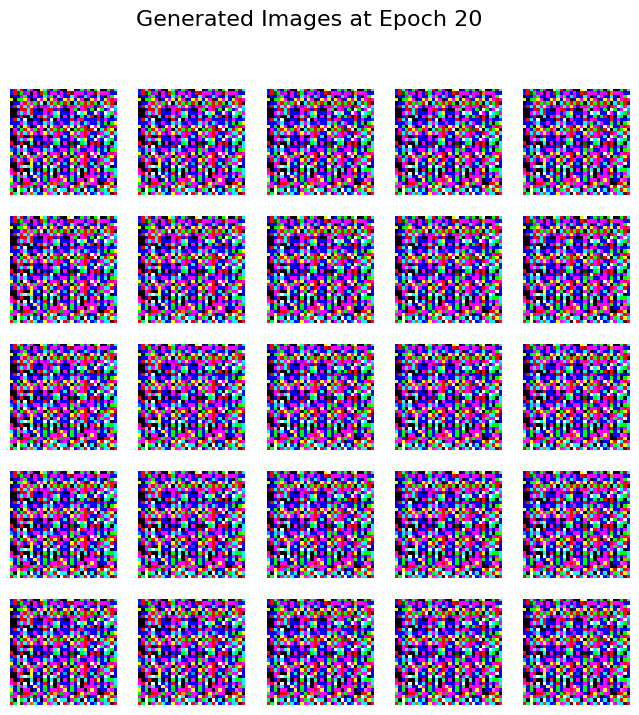

Epoch 21/200 | D Loss Real: 1.138 | D Loss Fake: 1.152 | G Loss: 0.285
Epoch 22/200 | D Loss Real: 1.119 | D Loss Fake: 1.123 | G Loss: 0.283
Epoch 23/200 | D Loss Real: 1.119 | D Loss Fake: 1.121 | G Loss: 0.281
Epoch 24/200 | D Loss Real: 1.119 | D Loss Fake: 1.121 | G Loss: 0.280
Epoch 25/200 | D Loss Real: 1.120 | D Loss Fake: 1.121 | G Loss: 0.278
Epoch 26/200 | D Loss Real: 1.120 | D Loss Fake: 1.121 | G Loss: 0.277
Epoch 27/200 | D Loss Real: 1.120 | D Loss Fake: 1.121 | G Loss: 0.275
Epoch 28/200 | D Loss Real: 1.121 | D Loss Fake: 1.122 | G Loss: 0.274
Epoch 29/200 | D Loss Real: 1.122 | D Loss Fake: 1.122 | G Loss: 0.273
Epoch 30/200 | D Loss Real: 1.122 | D Loss Fake: 1.123 | G Loss: 0.272
    -> Evaluation at Epoch 30: Accuracy Real: 21%, Fake: 0%


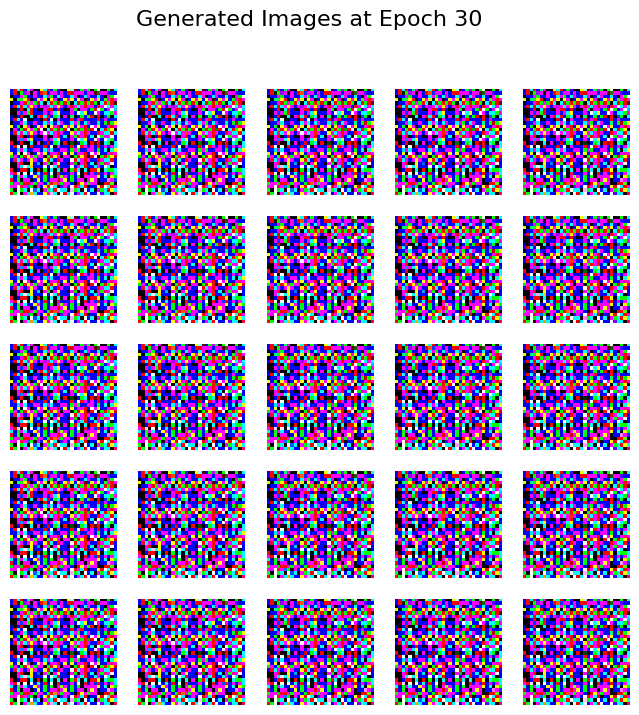

Epoch 31/200 | D Loss Real: 1.155 | D Loss Fake: 1.170 | G Loss: 0.270
Epoch 32/200 | D Loss Real: 1.134 | D Loss Fake: 1.137 | G Loss: 0.269
Epoch 33/200 | D Loss Real: 1.132 | D Loss Fake: 1.134 | G Loss: 0.268
Epoch 34/200 | D Loss Real: 1.131 | D Loss Fake: 1.132 | G Loss: 0.268
Epoch 35/200 | D Loss Real: 1.131 | D Loss Fake: 1.132 | G Loss: 0.267
Epoch 36/200 | D Loss Real: 1.131 | D Loss Fake: 1.132 | G Loss: 0.266
Epoch 37/200 | D Loss Real: 1.130 | D Loss Fake: 1.131 | G Loss: 0.265
Epoch 38/200 | D Loss Real: 1.130 | D Loss Fake: 1.131 | G Loss: 0.264
Epoch 39/200 | D Loss Real: 1.130 | D Loss Fake: 1.131 | G Loss: 0.264
Epoch 40/200 | D Loss Real: 1.130 | D Loss Fake: 1.131 | G Loss: 0.263
    -> Evaluation at Epoch 40: Accuracy Real: 31%, Fake: 0%


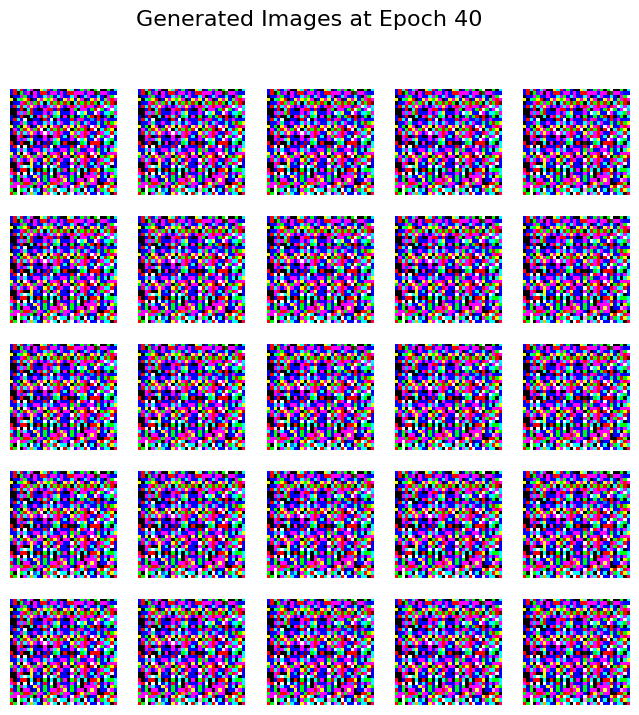

Epoch 41/200 | D Loss Real: 1.157 | D Loss Fake: 1.172 | G Loss: 0.262
Epoch 42/200 | D Loss Real: 1.136 | D Loss Fake: 1.140 | G Loss: 0.262
Epoch 43/200 | D Loss Real: 1.134 | D Loss Fake: 1.137 | G Loss: 0.261
Epoch 44/200 | D Loss Real: 1.134 | D Loss Fake: 1.136 | G Loss: 0.260
Epoch 45/200 | D Loss Real: 1.134 | D Loss Fake: 1.135 | G Loss: 0.260
Epoch 46/200 | D Loss Real: 1.134 | D Loss Fake: 1.135 | G Loss: 0.259
Epoch 47/200 | D Loss Real: 1.134 | D Loss Fake: 1.135 | G Loss: 0.259
Epoch 48/200 | D Loss Real: 1.134 | D Loss Fake: 1.135 | G Loss: 0.258
Epoch 49/200 | D Loss Real: 1.134 | D Loss Fake: 1.135 | G Loss: 0.258
Epoch 50/200 | D Loss Real: 1.134 | D Loss Fake: 1.135 | G Loss: 0.257
    -> Evaluation at Epoch 50: Accuracy Real: 23%, Fake: 0%


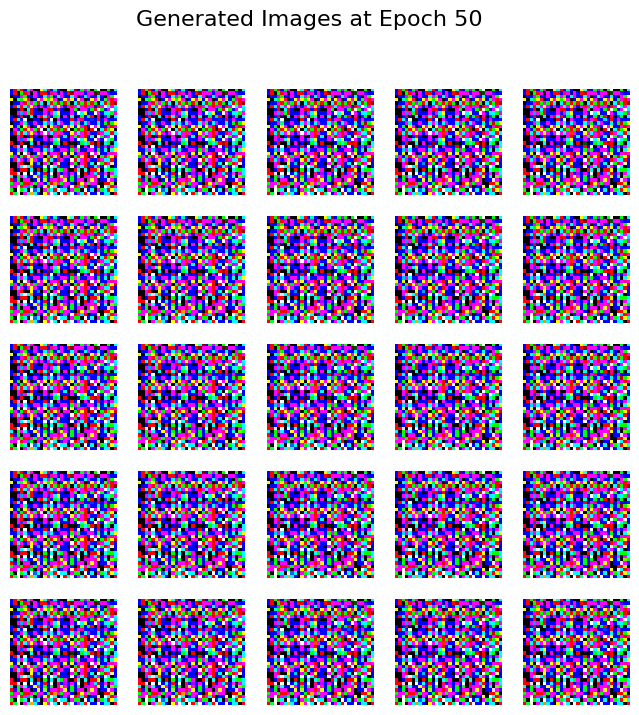

Epoch 51/200 | D Loss Real: 1.162 | D Loss Fake: 1.177 | G Loss: 0.257
Epoch 52/200 | D Loss Real: 1.141 | D Loss Fake: 1.145 | G Loss: 0.256
Epoch 53/200 | D Loss Real: 1.139 | D Loss Fake: 1.141 | G Loss: 0.256
Epoch 54/200 | D Loss Real: 1.138 | D Loss Fake: 1.140 | G Loss: 0.256
Epoch 55/200 | D Loss Real: 1.138 | D Loss Fake: 1.139 | G Loss: 0.255
Epoch 56/200 | D Loss Real: 1.137 | D Loss Fake: 1.138 | G Loss: 0.255
Epoch 57/200 | D Loss Real: 1.137 | D Loss Fake: 1.138 | G Loss: 0.254
Epoch 58/200 | D Loss Real: 1.137 | D Loss Fake: 1.138 | G Loss: 0.254
Epoch 59/200 | D Loss Real: 1.137 | D Loss Fake: 1.138 | G Loss: 0.254
Epoch 60/200 | D Loss Real: 1.138 | D Loss Fake: 1.138 | G Loss: 0.253
    -> Evaluation at Epoch 60: Accuracy Real: 23%, Fake: 0%


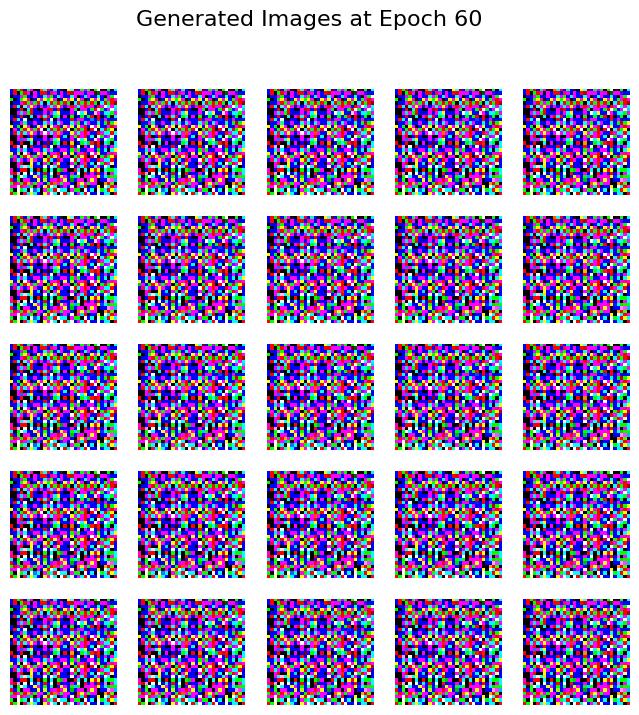

Epoch 61/200 | D Loss Real: 1.168 | D Loss Fake: 1.183 | G Loss: 0.253
Epoch 62/200 | D Loss Real: 1.147 | D Loss Fake: 1.150 | G Loss: 0.253
Epoch 63/200 | D Loss Real: 1.145 | D Loss Fake: 1.147 | G Loss: 0.252
Epoch 64/200 | D Loss Real: 1.144 | D Loss Fake: 1.146 | G Loss: 0.252
Epoch 65/200 | D Loss Real: 1.145 | D Loss Fake: 1.146 | G Loss: 0.251
Epoch 66/200 | D Loss Real: 1.145 | D Loss Fake: 1.146 | G Loss: 0.251
Epoch 67/200 | D Loss Real: 1.145 | D Loss Fake: 1.146 | G Loss: 0.251
Epoch 68/200 | D Loss Real: 1.146 | D Loss Fake: 1.147 | G Loss: 0.250
Epoch 69/200 | D Loss Real: 1.146 | D Loss Fake: 1.147 | G Loss: 0.250
Epoch 70/200 | D Loss Real: 1.146 | D Loss Fake: 1.147 | G Loss: 0.250
    -> Evaluation at Epoch 70: Accuracy Real: 19%, Fake: 0%


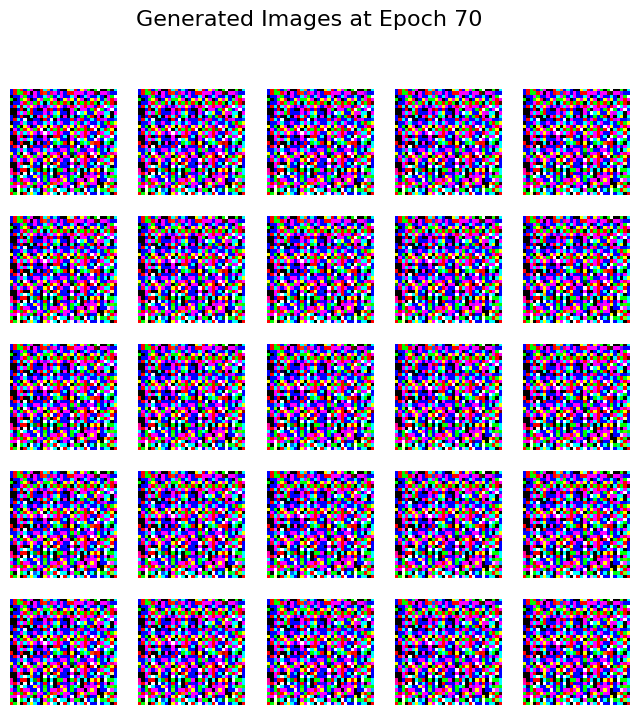

Epoch 71/200 | D Loss Real: 1.179 | D Loss Fake: 1.195 | G Loss: 0.249
Epoch 72/200 | D Loss Real: 1.157 | D Loss Fake: 1.161 | G Loss: 0.249
Epoch 73/200 | D Loss Real: 1.154 | D Loss Fake: 1.157 | G Loss: 0.249
Epoch 74/200 | D Loss Real: 1.154 | D Loss Fake: 1.155 | G Loss: 0.248
Epoch 75/200 | D Loss Real: 1.153 | D Loss Fake: 1.155 | G Loss: 0.248
Epoch 76/200 | D Loss Real: 1.153 | D Loss Fake: 1.154 | G Loss: 0.248
Epoch 77/200 | D Loss Real: 1.153 | D Loss Fake: 1.154 | G Loss: 0.247
Epoch 78/200 | D Loss Real: 1.153 | D Loss Fake: 1.154 | G Loss: 0.247
Epoch 79/200 | D Loss Real: 1.154 | D Loss Fake: 1.155 | G Loss: 0.247
Epoch 80/200 | D Loss Real: 1.154 | D Loss Fake: 1.155 | G Loss: 0.247
    -> Evaluation at Epoch 80: Accuracy Real: 19%, Fake: 0%


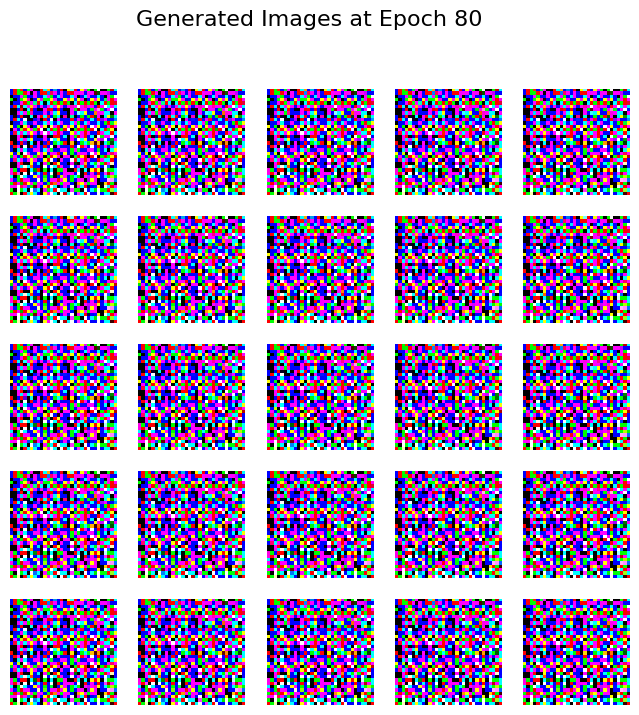

Epoch 81/200 | D Loss Real: 1.187 | D Loss Fake: 1.203 | G Loss: 0.246
Epoch 82/200 | D Loss Real: 1.165 | D Loss Fake: 1.169 | G Loss: 0.246
Epoch 83/200 | D Loss Real: 1.164 | D Loss Fake: 1.166 | G Loss: 0.246
Epoch 84/200 | D Loss Real: 1.163 | D Loss Fake: 1.165 | G Loss: 0.245
Epoch 85/200 | D Loss Real: 1.164 | D Loss Fake: 1.165 | G Loss: 0.245
Epoch 86/200 | D Loss Real: 1.164 | D Loss Fake: 1.165 | G Loss: 0.245
Epoch 87/200 | D Loss Real: 1.164 | D Loss Fake: 1.165 | G Loss: 0.244
Epoch 88/200 | D Loss Real: 1.164 | D Loss Fake: 1.165 | G Loss: 0.244
Epoch 89/200 | D Loss Real: 1.165 | D Loss Fake: 1.165 | G Loss: 0.244
Epoch 90/200 | D Loss Real: 1.165 | D Loss Fake: 1.166 | G Loss: 0.244
    -> Evaluation at Epoch 90: Accuracy Real: 22%, Fake: 0%


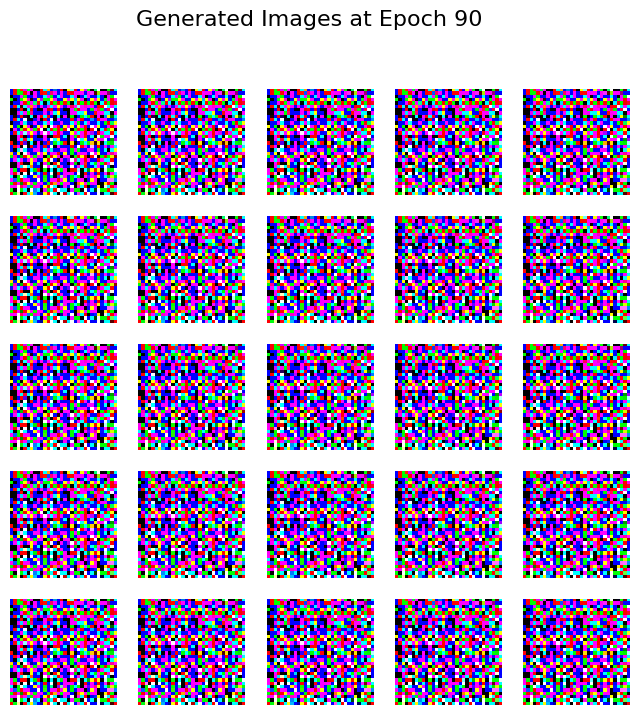

Epoch 91/200 | D Loss Real: 1.197 | D Loss Fake: 1.213 | G Loss: 0.243
Epoch 92/200 | D Loss Real: 1.176 | D Loss Fake: 1.180 | G Loss: 0.243
Epoch 93/200 | D Loss Real: 1.175 | D Loss Fake: 1.177 | G Loss: 0.243
Epoch 94/200 | D Loss Real: 1.174 | D Loss Fake: 1.176 | G Loss: 0.242
Epoch 95/200 | D Loss Real: 1.175 | D Loss Fake: 1.177 | G Loss: 0.242
Epoch 96/200 | D Loss Real: 1.177 | D Loss Fake: 1.178 | G Loss: 0.242
Epoch 97/200 | D Loss Real: 1.178 | D Loss Fake: 1.179 | G Loss: 0.241
Epoch 98/200 | D Loss Real: 1.179 | D Loss Fake: 1.179 | G Loss: 0.241
Epoch 99/200 | D Loss Real: 1.180 | D Loss Fake: 1.181 | G Loss: 0.241
Epoch 100/200 | D Loss Real: 1.181 | D Loss Fake: 1.182 | G Loss: 0.240
    -> Evaluation at Epoch 100: Accuracy Real: 25%, Fake: 0%


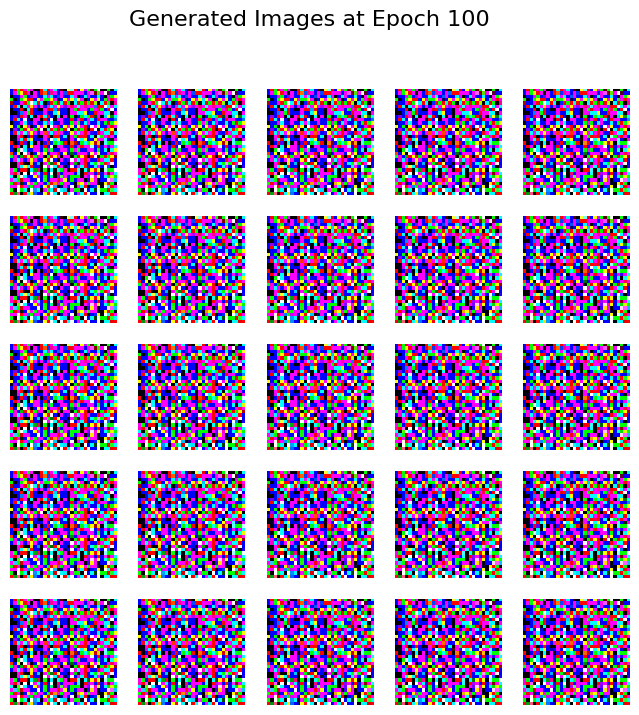

Epoch 101/200 | D Loss Real: 1.220 | D Loss Fake: 1.237 | G Loss: 0.240
Epoch 102/200 | D Loss Real: 1.196 | D Loss Fake: 1.201 | G Loss: 0.240
Epoch 103/200 | D Loss Real: 1.195 | D Loss Fake: 1.197 | G Loss: 0.239
Epoch 104/200 | D Loss Real: 1.194 | D Loss Fake: 1.196 | G Loss: 0.239
Epoch 105/200 | D Loss Real: 1.194 | D Loss Fake: 1.196 | G Loss: 0.239
Epoch 106/200 | D Loss Real: 1.195 | D Loss Fake: 1.196 | G Loss: 0.238
Epoch 107/200 | D Loss Real: 1.195 | D Loss Fake: 1.196 | G Loss: 0.238
Epoch 108/200 | D Loss Real: 1.196 | D Loss Fake: 1.196 | G Loss: 0.238
Epoch 109/200 | D Loss Real: 1.196 | D Loss Fake: 1.197 | G Loss: 0.237
Epoch 110/200 | D Loss Real: 1.197 | D Loss Fake: 1.197 | G Loss: 0.237
    -> Evaluation at Epoch 110: Accuracy Real: 30%, Fake: 0%


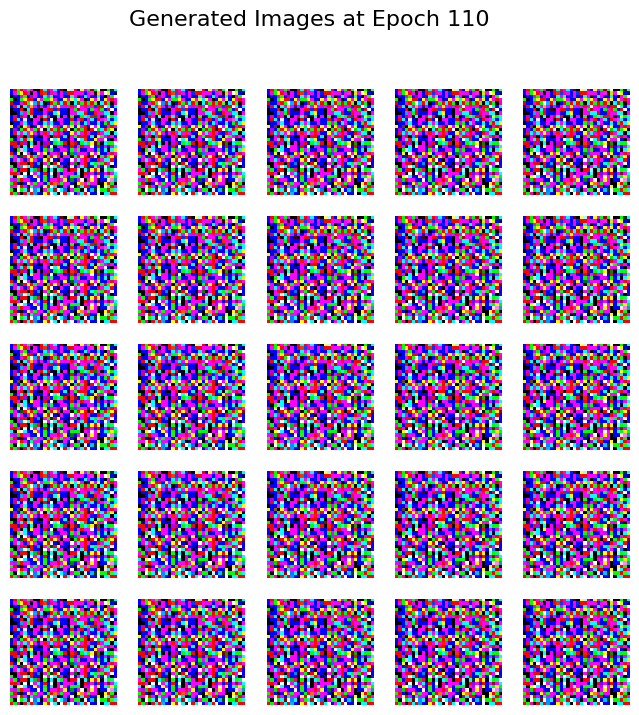

Epoch 111/200 | D Loss Real: 1.231 | D Loss Fake: 1.249 | G Loss: 0.237
Epoch 112/200 | D Loss Real: 1.208 | D Loss Fake: 1.212 | G Loss: 0.236
Epoch 113/200 | D Loss Real: 1.206 | D Loss Fake: 1.209 | G Loss: 0.236
Epoch 114/200 | D Loss Real: 1.205 | D Loss Fake: 1.207 | G Loss: 0.236
Epoch 115/200 | D Loss Real: 1.205 | D Loss Fake: 1.206 | G Loss: 0.235
Epoch 116/200 | D Loss Real: 1.205 | D Loss Fake: 1.206 | G Loss: 0.235
Epoch 117/200 | D Loss Real: 1.205 | D Loss Fake: 1.206 | G Loss: 0.235
Epoch 118/200 | D Loss Real: 1.205 | D Loss Fake: 1.206 | G Loss: 0.235
Epoch 119/200 | D Loss Real: 1.206 | D Loss Fake: 1.206 | G Loss: 0.234
Epoch 120/200 | D Loss Real: 1.206 | D Loss Fake: 1.207 | G Loss: 0.234
    -> Evaluation at Epoch 120: Accuracy Real: 21%, Fake: 0%


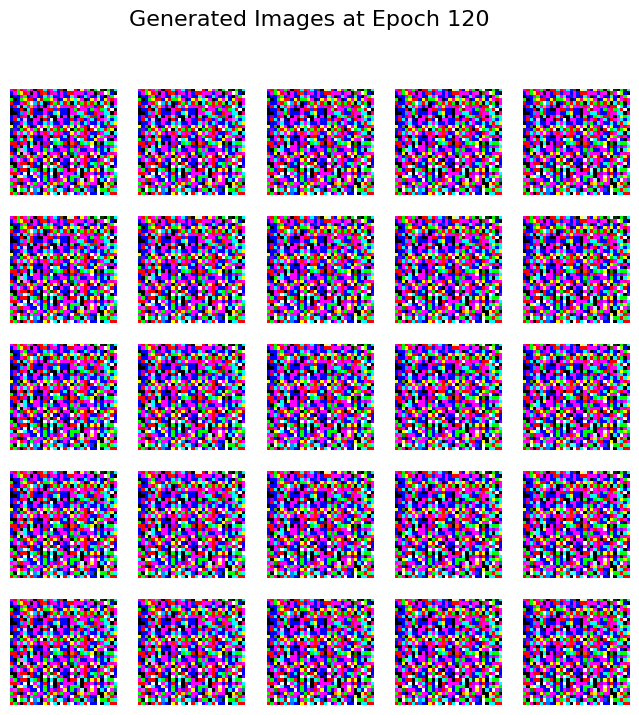

Epoch 121/200 | D Loss Real: 1.240 | D Loss Fake: 1.257 | G Loss: 0.234
Epoch 122/200 | D Loss Real: 1.215 | D Loss Fake: 1.220 | G Loss: 0.233
Epoch 123/200 | D Loss Real: 1.213 | D Loss Fake: 1.216 | G Loss: 0.233
Epoch 124/200 | D Loss Real: 1.213 | D Loss Fake: 1.215 | G Loss: 0.233
Epoch 125/200 | D Loss Real: 1.213 | D Loss Fake: 1.215 | G Loss: 0.233
Epoch 126/200 | D Loss Real: 1.214 | D Loss Fake: 1.215 | G Loss: 0.232
Epoch 127/200 | D Loss Real: 1.214 | D Loss Fake: 1.215 | G Loss: 0.232
Epoch 128/200 | D Loss Real: 1.214 | D Loss Fake: 1.215 | G Loss: 0.232
Epoch 129/200 | D Loss Real: 1.215 | D Loss Fake: 1.215 | G Loss: 0.231
Epoch 130/200 | D Loss Real: 1.215 | D Loss Fake: 1.216 | G Loss: 0.231
    -> Evaluation at Epoch 130: Accuracy Real: 20%, Fake: 0%


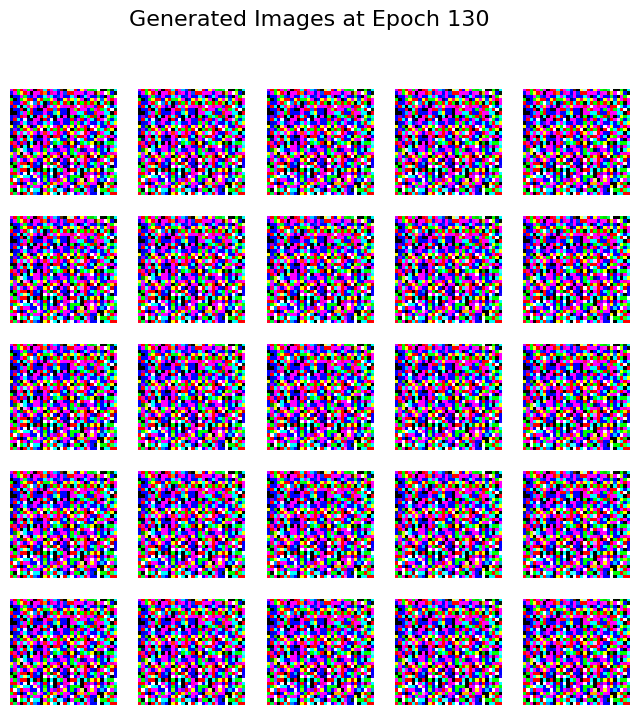

Epoch 131/200 | D Loss Real: 1.253 | D Loss Fake: 1.271 | G Loss: 0.231
Epoch 132/200 | D Loss Real: 1.229 | D Loss Fake: 1.234 | G Loss: 0.230
Epoch 133/200 | D Loss Real: 1.228 | D Loss Fake: 1.231 | G Loss: 0.230
Epoch 134/200 | D Loss Real: 1.228 | D Loss Fake: 1.230 | G Loss: 0.230
Epoch 135/200 | D Loss Real: 1.228 | D Loss Fake: 1.229 | G Loss: 0.230
Epoch 136/200 | D Loss Real: 1.228 | D Loss Fake: 1.229 | G Loss: 0.229
Epoch 137/200 | D Loss Real: 1.228 | D Loss Fake: 1.229 | G Loss: 0.229
Epoch 138/200 | D Loss Real: 1.229 | D Loss Fake: 1.230 | G Loss: 0.229
Epoch 139/200 | D Loss Real: 1.230 | D Loss Fake: 1.231 | G Loss: 0.228
Epoch 140/200 | D Loss Real: 1.231 | D Loss Fake: 1.231 | G Loss: 0.228
    -> Evaluation at Epoch 140: Accuracy Real: 22%, Fake: 0%


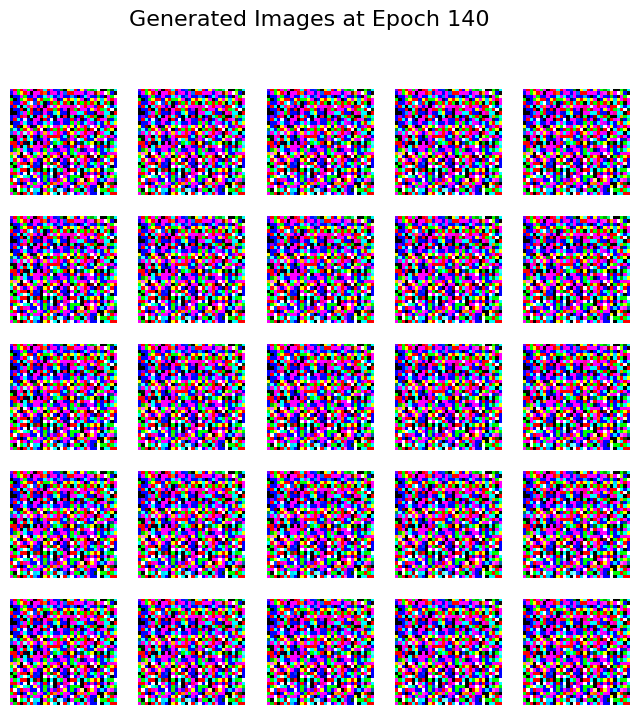

Epoch 141/200 | D Loss Real: 1.274 | D Loss Fake: 1.293 | G Loss: 0.228
Epoch 142/200 | D Loss Real: 1.249 | D Loss Fake: 1.254 | G Loss: 0.227
Epoch 143/200 | D Loss Real: 1.248 | D Loss Fake: 1.251 | G Loss: 0.227
Epoch 144/200 | D Loss Real: 1.249 | D Loss Fake: 1.251 | G Loss: 0.227
Epoch 145/200 | D Loss Real: 1.250 | D Loss Fake: 1.252 | G Loss: 0.227
Epoch 146/200 | D Loss Real: 1.251 | D Loss Fake: 1.252 | G Loss: 0.226
Epoch 147/200 | D Loss Real: 1.252 | D Loss Fake: 1.253 | G Loss: 0.226
Epoch 148/200 | D Loss Real: 1.254 | D Loss Fake: 1.255 | G Loss: 0.226
Epoch 149/200 | D Loss Real: 1.255 | D Loss Fake: 1.256 | G Loss: 0.225
Epoch 150/200 | D Loss Real: 1.257 | D Loss Fake: 1.257 | G Loss: 0.225
    -> Evaluation at Epoch 150: Accuracy Real: 19%, Fake: 0%


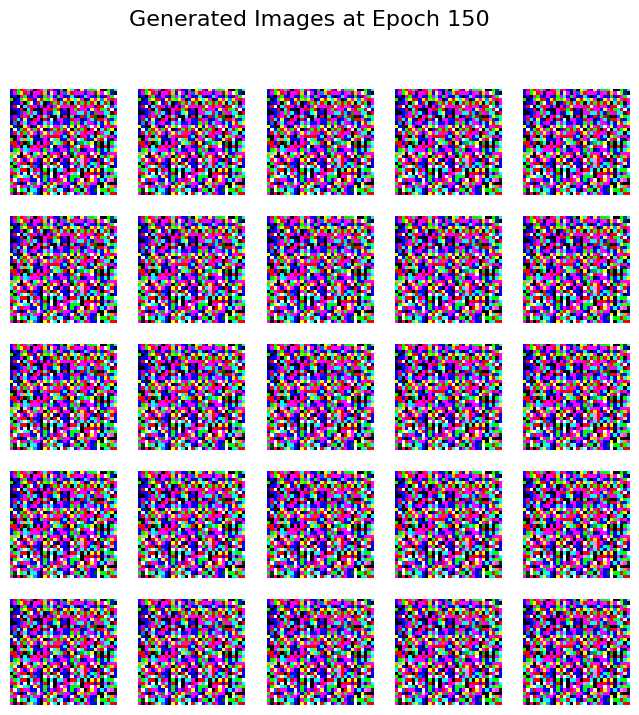

Epoch 151/200 | D Loss Real: 1.308 | D Loss Fake: 1.328 | G Loss: 0.225
Epoch 152/200 | D Loss Real: 1.282 | D Loss Fake: 1.287 | G Loss: 0.224
Epoch 153/200 | D Loss Real: 1.280 | D Loss Fake: 1.283 | G Loss: 0.224
Epoch 154/200 | D Loss Real: 1.280 | D Loss Fake: 1.282 | G Loss: 0.223
Epoch 155/200 | D Loss Real: 1.280 | D Loss Fake: 1.282 | G Loss: 0.223
Epoch 156/200 | D Loss Real: 1.281 | D Loss Fake: 1.282 | G Loss: 0.223
Epoch 157/200 | D Loss Real: 1.282 | D Loss Fake: 1.283 | G Loss: 0.222
Epoch 158/200 | D Loss Real: 1.283 | D Loss Fake: 1.284 | G Loss: 0.222
Epoch 159/200 | D Loss Real: 1.284 | D Loss Fake: 1.285 | G Loss: 0.222
Epoch 160/200 | D Loss Real: 1.285 | D Loss Fake: 1.285 | G Loss: 0.221
    -> Evaluation at Epoch 160: Accuracy Real: 25%, Fake: 0%


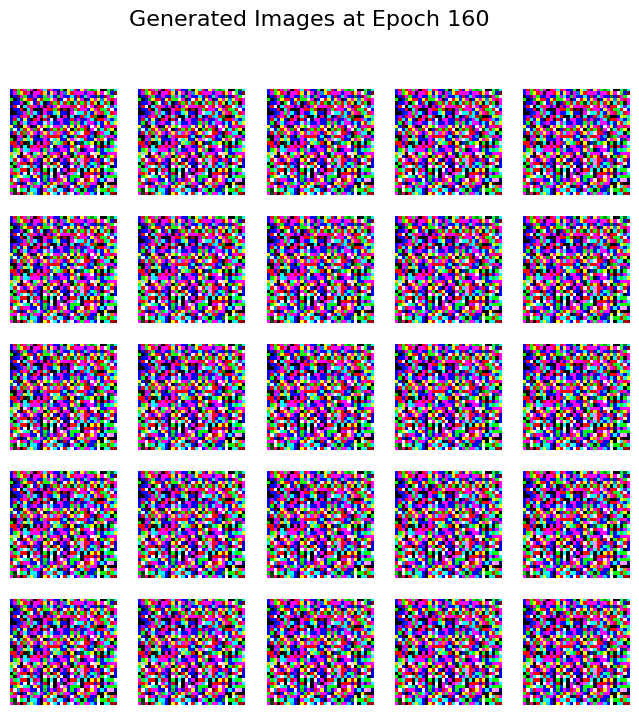

Epoch 161/200 | D Loss Real: 1.332 | D Loss Fake: 1.353 | G Loss: 0.221
Epoch 162/200 | D Loss Real: 1.303 | D Loss Fake: 1.308 | G Loss: 0.221
Epoch 163/200 | D Loss Real: 1.300 | D Loss Fake: 1.303 | G Loss: 0.220
Epoch 164/200 | D Loss Real: 1.299 | D Loss Fake: 1.301 | G Loss: 0.220
Epoch 165/200 | D Loss Real: 1.299 | D Loss Fake: 1.301 | G Loss: 0.220
Epoch 166/200 | D Loss Real: 1.300 | D Loss Fake: 1.301 | G Loss: 0.219
Epoch 167/200 | D Loss Real: 1.300 | D Loss Fake: 1.301 | G Loss: 0.219
Epoch 168/200 | D Loss Real: 1.300 | D Loss Fake: 1.302 | G Loss: 0.219
Epoch 169/200 | D Loss Real: 1.301 | D Loss Fake: 1.302 | G Loss: 0.218
Epoch 170/200 | D Loss Real: 1.301 | D Loss Fake: 1.302 | G Loss: 0.218
    -> Evaluation at Epoch 170: Accuracy Real: 26%, Fake: 0%


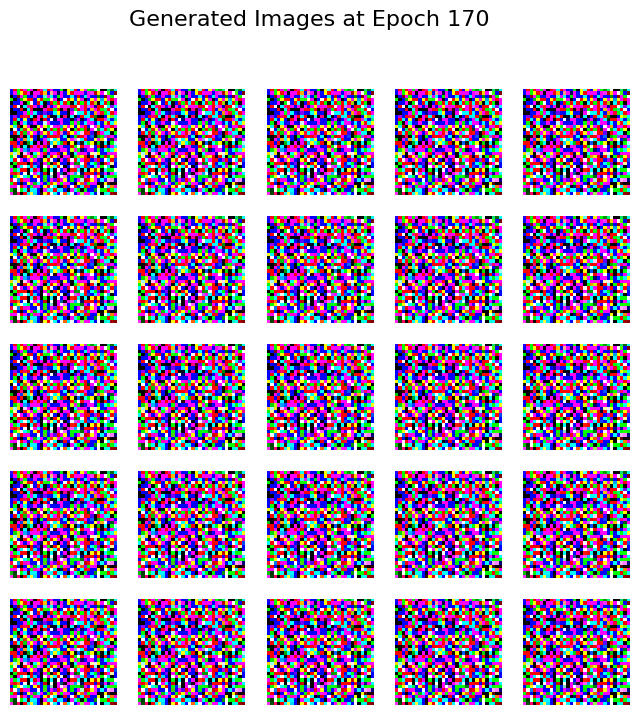

Epoch 171/200 | D Loss Real: 1.343 | D Loss Fake: 1.364 | G Loss: 0.218
Epoch 172/200 | D Loss Real: 1.313 | D Loss Fake: 1.318 | G Loss: 0.217
Epoch 173/200 | D Loss Real: 1.310 | D Loss Fake: 1.313 | G Loss: 0.217
Epoch 174/200 | D Loss Real: 1.309 | D Loss Fake: 1.311 | G Loss: 0.217
Epoch 175/200 | D Loss Real: 1.309 | D Loss Fake: 1.311 | G Loss: 0.216
Epoch 176/200 | D Loss Real: 1.309 | D Loss Fake: 1.310 | G Loss: 0.216
Epoch 177/200 | D Loss Real: 1.309 | D Loss Fake: 1.310 | G Loss: 0.216
Epoch 178/200 | D Loss Real: 1.309 | D Loss Fake: 1.310 | G Loss: 0.215
Epoch 179/200 | D Loss Real: 1.310 | D Loss Fake: 1.311 | G Loss: 0.215
Epoch 180/200 | D Loss Real: 1.310 | D Loss Fake: 1.311 | G Loss: 0.215
    -> Evaluation at Epoch 180: Accuracy Real: 15%, Fake: 0%


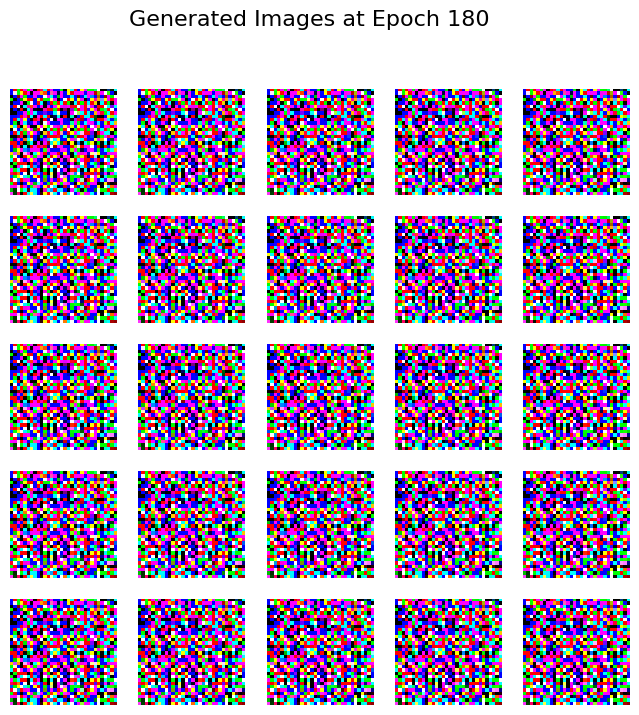

Epoch 181/200 | D Loss Real: 1.352 | D Loss Fake: 1.374 | G Loss: 0.214
Epoch 182/200 | D Loss Real: 1.322 | D Loss Fake: 1.327 | G Loss: 0.214
Epoch 183/200 | D Loss Real: 1.319 | D Loss Fake: 1.322 | G Loss: 0.214
Epoch 184/200 | D Loss Real: 1.318 | D Loss Fake: 1.321 | G Loss: 0.213
Epoch 185/200 | D Loss Real: 1.318 | D Loss Fake: 1.320 | G Loss: 0.213
Epoch 186/200 | D Loss Real: 1.318 | D Loss Fake: 1.320 | G Loss: 0.213
Epoch 187/200 | D Loss Real: 1.318 | D Loss Fake: 1.320 | G Loss: 0.212
Epoch 188/200 | D Loss Real: 1.318 | D Loss Fake: 1.319 | G Loss: 0.212
Epoch 189/200 | D Loss Real: 1.318 | D Loss Fake: 1.319 | G Loss: 0.212
Epoch 190/200 | D Loss Real: 1.319 | D Loss Fake: 1.319 | G Loss: 0.212
    -> Evaluation at Epoch 190: Accuracy Real: 21%, Fake: 0%


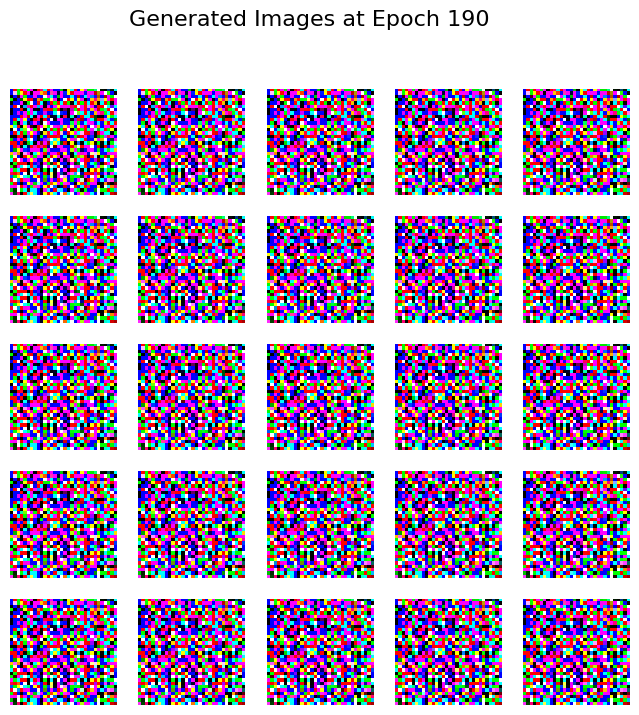

Epoch 191/200 | D Loss Real: 1.357 | D Loss Fake: 1.379 | G Loss: 0.211
Epoch 192/200 | D Loss Real: 1.327 | D Loss Fake: 1.333 | G Loss: 0.211
Epoch 193/200 | D Loss Real: 1.325 | D Loss Fake: 1.328 | G Loss: 0.211
Epoch 194/200 | D Loss Real: 1.323 | D Loss Fake: 1.325 | G Loss: 0.210
Epoch 195/200 | D Loss Real: 1.322 | D Loss Fake: 1.324 | G Loss: 0.210
Epoch 196/200 | D Loss Real: 1.322 | D Loss Fake: 1.324 | G Loss: 0.210
Epoch 197/200 | D Loss Real: 1.322 | D Loss Fake: 1.324 | G Loss: 0.210
Epoch 198/200 | D Loss Real: 1.322 | D Loss Fake: 1.323 | G Loss: 0.209
Epoch 199/200 | D Loss Real: 1.322 | D Loss Fake: 1.323 | G Loss: 0.209
Epoch 200/200 | D Loss Real: 1.323 | D Loss Fake: 1.323 | G Loss: 0.209
    -> Evaluation at Epoch 200: Accuracy Real: 19%, Fake: 0%


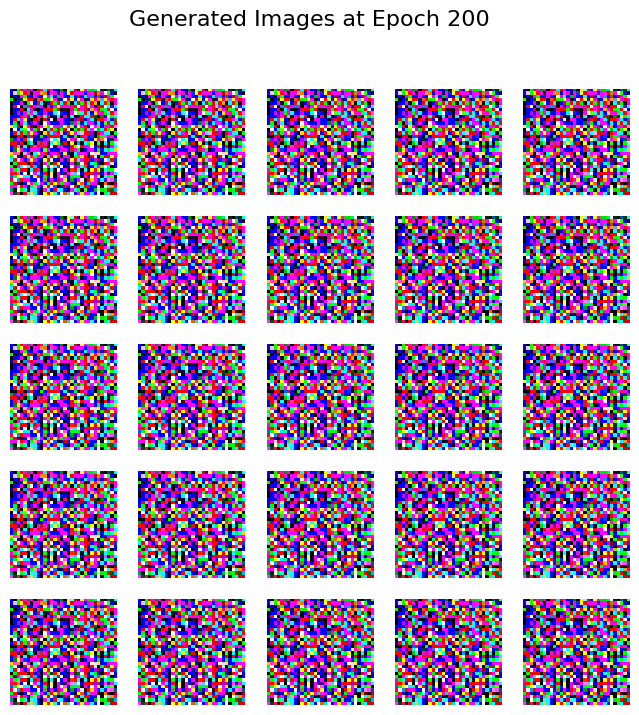

In [20]:
import numpy as np

def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128):
    """
    Trains the GAN models with clean, per-epoch summary reporting.
    This version does NOT print output for every batch.
    """
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)

    # Manually enumerate epochs
    for i in range(n_epochs):
        # Initialize lists to store losses from each batch in this epoch
        d_loss_real_list, d_loss_fake_list, g_loss_list = [], [], []

        # Enumerate batches over the training set
        for j in range(bat_per_epo):
            # -----------------------------
            #  Train the Discriminator
            # -----------------------------
            # Get a half-batch of real images and train
            X_real, y_real = generate_real_samples(dataset, half_batch)
            d_loss_real, _ = d_model.train_on_batch(X_real, y_real)

            # Get a half-batch of fake images and train
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            d_loss_fake, _ = d_model.train_on_batch(X_fake, y_fake)

            # -----------------------------
            #  Train the Generator
            # -----------------------------
            # Prepare latent points and inverted labels
            X_gan = generate_latent_points(latent_dim, n_batch)
            y_gan = np.ones((n_batch, 1))

            # Update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch(X_gan, y_gan)

            # Store the losses from this batch
            d_loss_real_list.append(d_loss_real)
            d_loss_fake_list.append(d_loss_fake)
            g_loss_list.append(g_loss)

        # --- Summarize and Print Performance at the End of Each Epoch ---
        d_loss_real_avg = np.mean(d_loss_real_list)
        d_loss_fake_avg = np.mean(d_loss_fake_list)
        g_loss_avg = np.mean(g_loss_list)

        # Print a single summary line for the completed epoch
        print(f"Epoch {i+1}/{n_epochs} | D Loss Real: {d_loss_real_avg:.3f} | D Loss Fake: {d_loss_fake_avg:.3f} | G Loss: {g_loss_avg:.3f}")

        # Evaluate model performance and visualize output every 10 epochs
        if (i + 1) % 10 == 0:
            summarize_performance(i, g_model, d_model, dataset, latent_dim)

# --- Putting It All Together: Start Training ---

# 1. Define hyperparameters
latent_dim = 100
n_epochs = 200
n_batch = 128

# 2. Create the models
d_model = define_discriminator()
g_model = define_generator(latent_dim)
gan_model = define_gan(g_model, d_model)

# 3. Load and prepare real data (use the car-specific version if desired)
dataset = load_real_samples()

# 4. Train the model
print("\n--- Starting Full GAN Training (Clean Output) ---")
train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs, n_batch)